In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import waltlabtools as wlt

from config import (
    FIND28_ISINGLE_MULTIPLIER,
    HDX_RESULTS_DIR,
    LOD_COL_FMT,
    OUTPUT_DIR,
    PROCESSED_DIR,
)
from utils import Barcode2, get_isingle_aeb

# 01 Calibration

This notebook reads in the raw HD-X files, generates calibration curves, plots calibration curves, calculates concentrations, and collates the biomarker data tables:
- `X_med`: median concentration across all replicates, indexed by barcode
- `X_reps`: concentrations of all replicates individually, indexed by barcode and replicate number
- `X_all`: concatenation of `X_med` and `X_reps`, indexed by barcode and replicate number, where replicate 0 is the median

## Read files, correct errors, and calculate concentrations

Here we calculate Isingle for FIND28 as in [Quanterix _Anal. Chem._ 2023](https://doi.org/10.1021/acs.analchem.3c00918) and then arbitrarily down-scale it by 0.6 to make the calibration curve fit best. Replicate AEB is a weighted average of analog and digital AEB using [Quanterix _Anal. Chem._ 2023](https://doi.org/10.1021/acs.analchem.3c00918). Calibration curves are linear because this fits as well as 4PL does with fewer free parameters and better interpretability.

In [2]:
# READ FILES
q = wlt.HDX(HDX_RESULTS_DIR, assay_defining_cols=["Batch Name", "Plex"])

# FIX DATA ENTRY ERRORS

# Accidentally entered the same barcode twice
q.raw.loc[
    q.raw.index[
        (q.raw["Batch Name"] == "02162024 Run1 Hydrogen")
        & (q.raw.Location.str.endswith("H9"))
    ],
    "Sample Barcode",
] = "01014648301"

# Omitted zeros when typing barcodes during rerun
for barcode in ["026010082U001", "026010157U001", "026020058U001"]:
    split = barcode.partition("U")
    new_barcode = f"{split[0]}000U{split[2]}"
    q.raw.loc[
        q.raw.index[
            (q.raw["Batch Name"] == "02222024 TB Run6 Carbon")
            & (q.raw["Sample Barcode"] == barcode)
        ],
        "Sample Barcode",
    ] = new_barcode
# Omitted "1" when typing in barcode
q.raw["Sample Barcode"] = q.raw["Sample Barcode"].replace({"0160523301": "01610523301"})
is_specimen = q.raw["Sample Type"] == "Specimen"
# Convert sample barcodes to Barcode objects
# q.raw["Sample Barcode"] = q.raw["Sample Barcode"].astype(BarcodeDtype())

# CALCULATE AEBS AND CONCENTRATIONS
q.raw = get_isingle_aeb(q.raw, {"700 LAM FIND28": FIND28_ISINGLE_MULTIPLIER})
q.calculate_cal_curves(model="linear")


# Concentrations
def get_conc(row):
    return q.cal_curves[row["Batch Name"], row["Plex"]].conc(row["Replicate AEB"])


q.raw.loc[is_specimen, "Replicate Conc."] = q.raw[is_specimen].apply(get_conc, axis=1)

## Plot calibration curves (Figure 1)

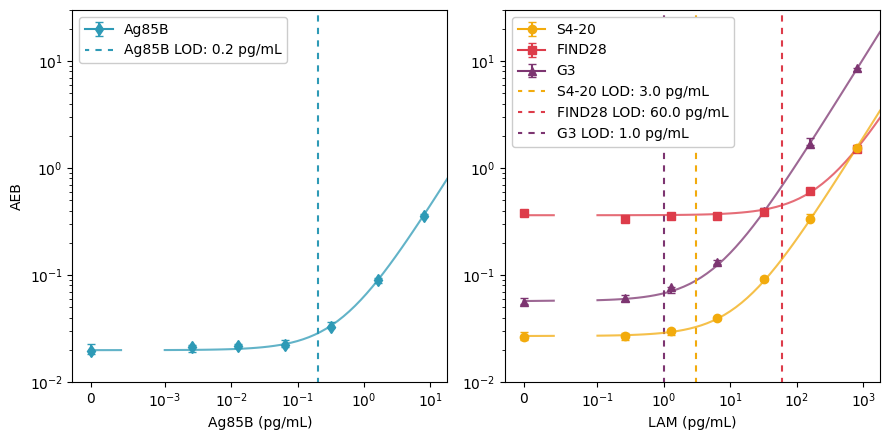

In [3]:
cc_batches = sorted(q.raw["Batch Name"].unique())[:6]
kws = {"capsize": 3}
xmins = [1e-3, 0.1]

fig, axs = plt.subplots(ncols=2, figsize=(9, 4.5))

# for plex, (color, lod, fmt) in color_lod_fmt.items():
for plex, lod, __, color, fmt in LOD_COL_FMT.itertuples():
    if plex == "488 Ag85B 182":
        a = 0
        label = "Ag85B"
    else:
        a = 1
        label = plex.split()[-1]

    # Points
    aebs = q.raw[
        q.raw["Batch Name"].isin(cc_batches)
        & (q.raw.Plex == plex)
        & (q.raw["Sample Type"] == "Calibrator")
        & (q.raw["Replicate AEB"].notna())
    ].groupby("Replicate Conc.")["Replicate AEB"]
    cc_y = aebs.median()
    cc_x = cc_y.index
    yerr = abs(aebs.quantile(np.array([0.25, 0.75])).unstack().sub(cc_y, axis=0)).T
    axs[a].errorbar(cc_x, cc_y, yerr=yerr, fmt=fmt, color=color, **kws)
    axs[a].errorbar(
        [-np.inf], [-np.inf], yerr=[1], fmt=f"{fmt}-", color=color, label=label, **kws
    )

    # Curve
    coef = [
        q.cal_curves.loc[(cc_batches, plex)].map(lambda cc: cc.coef_[i]).median()
        for i in range(2)
    ]
    xmax = 8000 * np.sqrt(5) * xmins[a]
    x = np.array(
        [0, np.log10(2.56) * xmins[a]]
        + [np.nan]
        + list(np.geomspace(xmins[a], xmax, num=50))
    )
    axs[a].plot(x, wlt.linear(x, *coef), "-", color=color, alpha=0.75)

    # Limit of detection
    axs[a].axvline(
        lod,
        ls=(1, (3, 3)),
        color=color,
        label=f"{label} LOD: {lod} pg/mL",
    )

for a, marker in enumerate(["Ag85B", "LAM"]):
    axs[a].set(
        xlim=(-xmins[a] / 4, 8000 * np.sqrt(5) * xmins[a]),
        ylim=(0.01, 30),
        yscale="log",
        xlabel=f"{marker} (pg/mL)",
    )
    axs[a].set_xscale("symlog", linthresh=xmins[a])
    axs[a].legend(loc="upper left", reverse=True, framealpha=1)

axs[0].set(ylabel="AEB")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "f1.pdf")

## Generate feature matrices

In [4]:
def get_barcode_any_aliquot(barcode):
    if isinstance(barcode, str) and barcode.startswith("Calibrator"):
        return barcode
    return Barcode2(barcode).any_aliquot()


q.raw["Barcode Any Aliquot"] = q.raw["Sample Barcode"].map(get_barcode_any_aliquot)
q.raw["Replicate"] = (
    q.raw.groupby("Barcode Any Aliquot")["Job ID"].rank(method="dense").convert_dtypes()
)

X_med = (
    q.raw[q.raw["Sample Type"] == "Specimen"]
    .pivot_table(
        columns="Plex",
        index="Barcode Any Aliquot",
        values="Replicate Conc.",
        aggfunc="median",
    )
    .rename_axis(index=None)
)
X_rep = (
    q.raw[q.raw["Sample Type"] == "Specimen"]
    .pivot_table(
        columns="Plex",
        index=["Barcode Any Aliquot", "Replicate"],
        values="Replicate Conc.",
    )
    .rename_axis(index=[None, None])
)

X_med_re = X_med.copy()
X_med_re.index = pd.MultiIndex.from_arrays([X_med.index, np.zeros_like(X_med.index)])
X_all = pd.concat([X_med_re, X_rep]).sort_index()

X_med.to_csv(PROCESSED_DIR / "X_med.csv")
X_rep.to_csv(PROCESSED_DIR / "X_rep.csv")
X_all.to_csv(PROCESSED_DIR / "X_all.csv")
q.raw[["Barcode Any Aliquot", "Sample Barcode"]].drop_duplicates().to_csv(
    PROCESSED_DIR / "barcodes.csv", index=False
)